In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

##LOAD LLAVA 13B

In [ ]:
#@title load function
%%capture

%cd /content
!git clone -b v1.0 https://github.com/camenduru/LLaVA
%cd /content/LLaVA

!pip install -q transformers==4.36.2
!pip install -q gradio .

from transformers import AutoTokenizer, BitsAndBytesConfig
from llava.model import LlavaLlamaForCausalLM
import torch

import requests
from PIL import Image
from io import BytesIO
from transformers import TextStreamer

model_path = "4bit/llava-v1.5-13b-3GB"
kwargs = {"device_map": "auto"}
kwargs['load_in_4bit'] = True
kwargs['quantization_config'] = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type='nf4'
)
model = LlavaLlamaForCausalLM.from_pretrained(model_path, low_cpu_mem_usage=True, **kwargs)
tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False)

vision_tower = model.get_vision_tower()
if not vision_tower.is_loaded:
    vision_tower.load_model()
vision_tower.to(device='cuda')
image_processor = vision_tower.image_processor

%cd ..

In [ ]:
#@title LLAVA caption image function
from llava.conversation import conv_templates, SeparatorStyle
from llava.utils import disable_torch_init
from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.mm_utils import tokenizer_image_token, get_model_name_from_path, KeywordsStoppingCriteria

def caption_image(image_input, prompt):
    if isinstance(image_input, np.ndarray):
        # Convert numpy array to PIL Image
        image_input = image_input[:, :, ::-1]
        image = Image.fromarray(image_input).convert('RGB')
    elif isinstance(image_input, str):
        if image_input.startswith('http') or image_input.startswith('https'):
            response = requests.get(image_input)
            image = Image.open(BytesIO(response.content)).convert('RGB')
        else:
            image = Image.open(image_input).convert('RGB')
    else:
        raise ValueError("image_input must be a numpy array or a string.")

    disable_torch_init()
    conv_mode = "llava_v0"
    conv = conv_templates[conv_mode].copy()
    roles = conv.roles
    image_tensor = image_processor.preprocess(image, return_tensors='pt')['pixel_values'].half().cuda()
    inp = f"{roles[0]}: {prompt}"
    inp = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + inp
    conv.append_message(conv.roles[0], inp)
    conv.append_message(conv.roles[1], None)
    raw_prompt = conv.get_prompt()
    input_ids = tokenizer_image_token(raw_prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).cuda()
    stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
    keywords = [stop_str]
    stopping_criteria = KeywordsStoppingCriteria(keywords, tokenizer, input_ids)
    with torch.inference_mode():
      output_ids = model.generate(input_ids, images=image_tensor, do_sample=True, temperature=0.2,
                                  max_new_tokens=50, use_cache=True, stopping_criteria=[stopping_criteria])
    outputs = tokenizer.decode(output_ids[0, input_ids.shape[1]:]).strip()
    conv.messages[-1][-1] = outputs
    output = outputs.rsplit('</s>', 1)[0]
    return output

## Captions H5 Dataset

Caption generation from the frames saved in the H5 dataset

In [ ]:
!cp "/content/drive/MyDrive/Columbia Dataset/Speaker Frames/database.h5" "/content/data.h5"

In [ ]:
dataset_path = "/content/data.h5"

In [ ]:
# Define which speaker to caption and what prompt to use
speaker = 'sick'
prompt = "Is the person talking or not? Explain why in a few words"

In [ ]:
# Store result
text_captions = []

In [ ]:
#@title Caption generation for each video segment of the specified speaker
import h5py
start_len = len(text_captions)
with h5py.File(dataset_path, 'r') as f:
    person = f[speaker]
    frames = person['frames']
    labels = person['labels']
    frame_index = 0
    progress_bar = tqdm(total=len(labels), position=0, leave=True)

    # Organize frames using 'Frame Interpolation' to get fixed segments of length=10
    while frame_index < len(frames):
        current_label = labels[frame_index]
        current_frames = []
        original_frames_count = 0
        while len(current_frames) < 10 and frame_index < len(frames):
            if labels[frame_index] == current_label:
                current_frames.append(frames[frame_index])
                original_frames_count += 1
                frame_index += 1
            else:
                break
        while len(current_frames) < 10:
            current_frames += current_frames[:10 - len(current_frames)]

        # Generate caption based on the central frame of the video segment
        caption = caption_image(current_frames[4], prompt)

        key = f"{speaker}_{frame_index - len(current_frames)}_{frame_index - 1}"
        text_captions[key] = (speaker, current_label, caption, original_frames_count)
        progress_bar.update(10)
end_len = len(text_captions)

print(f"Nuovi aggiunti: {end_len-start_len} \t TOTALE: {end_len}")

38580it [3:19:08,  2.07it/s]

Nuovi aggiunti: 3858 	 TOTALE: 13732


In [ ]:
np.save("/content/drive/MyDrive/CLIP_embeddings/LLaVa_long_captions.npy", text_captions)

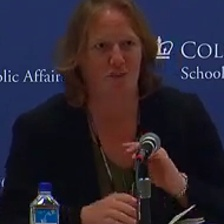

Yes, the person is talking. They are giving a speech or presentation at a podium, with a microphone to amplify their voice.


In [ ]:
#@title Result Example
import h5py
with h5py.File(dataset_path, 'r') as f:
  group = f['bell']
  frame = group['frames'][1000]
  cv2.imwrite('test.jpg', frame)
  display(ImageIPython('test.jpg'))
  caption = caption_image(frame, "Is the person talking or not? Explain why in a few words")
  if len(caption) > 250:
    print(f"attenzione lunghezza esagerata: {len(caption)}")
    caption = caption[:250]
  print(caption)

## LLaVA Accuracy measurement

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

prev_caption = None
y_true = []
y_pred = []

# Iterate over the dictionary
for key in [k for k in new_captions.keys() if k.startswith('lieberman')]:
    speaker, label, caption, original_frames_count = new_captions[key]

    # If caption doesn't start with "yes" or "no", use the previous caption
    if not caption.lower().startswith(("yes", "no")) and prev_caption is not None:
        caption = prev_caption

    # Check if caption starts with "yes" or "no"
    if caption.lower().startswith("yes"):
        y_pred.append(1)
    else:
        y_pred.append(0)

    y_true.append(label)

    # Update previous caption
    prev_caption = caption

# Calculate and print accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"The accuracy is: {accuracy}")

# Calculate and print macro F1 score
macro_f1_score = f1_score(y_true, y_pred, average='macro')
print(f"The macro F1 score is: {macro_f1_score}")

# Calculate and print weighted F1 score
weighted_f1_score = f1_score(y_true, y_pred, average='weighted')
print(f"The weighted F1 score is: {weighted_f1_score}")


The accuracy is: 0.8149726110772977
The macro F1 score is: 0.6378664315627067
The weighted F1 score is: 0.7696556251962795
